# Imports

In [1]:
import os
from PIL import Image
import pandas as pd
import numpy as np
import shutil
import matplotlib.pyplot as plt
import csv
import pickle
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 4090


# Input pipeline and preprocessing

## Classifier

### Create classification datasets

For creating the datasets, the training images, test images and test labels have to be downloaded and extracted. They should be saved in the `data` directory, with a structure like this:

```plaintext
data/
    classifier/
        Training/
            00000/
                ...
            00001/
                ...
        Test/
            00000.ppm
            ...
            GT-final_test.csv
```    

In [ ]:
# function for reading the images
# arguments: path to the traffic sign data, for example './GTSRB/Training'
# returns: list of images, list of corresponding labels 
def readTrafficSigns(rootpath, is_test=False):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    
    if not is_test:
        images = [] # images
        labels = [] # corresponding labels
        # loop over all 42 classes
        for c in range(0,43):
            prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
            gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
            gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
            next(gtReader) # skip header
            # loop over all images in current annotations file
            for row in gtReader:
                images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
                # TODO: Add not only the label but also the location of the bounding box
                labels.append(row[7]) # the 8th column is the label
            gtFile.close()
        return images, labels
    
    if is_test:
        # test images are not in seperate directories and have one annotation file with all annotations
        images = [] # images
        labels = []
        prefix = rootpath + '/'
        gtFile = open(prefix + 'GT-final_test.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';')
        next(gtReader) # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            # TODO: Add not only the label but also the location of the bounding box
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
        return images, labels

X, y = readTrafficSigns('./data/Training')
X_test, y_test = readTrafficSigns('./data/Test', is_test=True)

# split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=21)

# Dictionaries erstellen
train = {'features': X_train, 'labels': y_train}
val = {'features': X_val, 'labels': y_val}
test  = {'features': X_test,  'labels': y_test}

# Speichern
with open('./data/classifier/classifier_train.pkl', 'wb') as f:
    pickle.dump(train, f)
with open('./data/classifier/classifier_valid.pkl', 'wb') as f:
    pickle.dump(val, f)
with open('./data/classifier/classifier_test.pkl', 'wb') as f:
    pickle.dump(test, f)

### Visualization

In [ ]:
training_file   = './data/classifier/classifier_train.pkl'
validation_file = './data/classifier/classifier_valid.pkl'
testing_file    = './data/classifier/classifier_test.pkl'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels'] # training dataset
X_valid, y_valid = valid['features'], valid['labels'] # validation dataset used in training phase
X_test, y_test   = test['features'], test['labels']   # test dataset
n_classes        = len(np.unique(y_train))

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
#assert(len(X_test) == len(y_test))

print()
print("Image Shape    : {}".format(X_train[0].shape))
print()
print("Training Set   : {} samples".format(len(X_train)))
print("Validation Set : {} samples".format(len(X_valid)))
print("Test Set       : {} samples".format(len(X_test)))
print('n_classes      : {}'.format(n_classes))
X_train[0].shape
#X_train.shape


Image Shape    : (46, 50, 3)

Training Set   : 35288 samples
Validation Set : 3921 samples
Test Set       : 12630 samples
n_classes      : 43


(46, 50, 3)

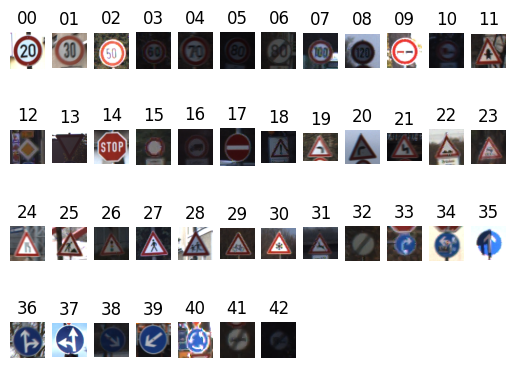

In [ ]:
%matplotlib inline
rows, cols   = 4, 12
fig, axes    = plt.subplots(rows, cols)
for idx, ax in enumerate(axes.ravel()):
    if idx < n_classes :
        # get X_train of the current class
        X_train_of_class = [X_train[i] for i in range(len(X_train)) if y_train[i] == str(idx)]
        # show a random image of the current class
        X_train_0       = X_train_of_class[np.random.randint(len(X_train_of_class))]
        ax.imshow(X_train_0)
        ax.set_title('{:02d}'.format(idx))
        ax.axis('off')
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
    else:
        ax.axis('off')
#
plt.draw()
fig.savefig('figures/' + 'sample_representative' + '.jpg', dpi=700)

## Object detection

### Create datasets

In [ ]:
# function for converting Roi.X1;Roi.Y1;Roi.X2;Roi.Y2 labels to X.center, Y.center, Width, Height
# Roi.X1 and Roi.Y1 are the coordinates of the top left corner of the bounding box, with Roi.X2 and Roi.Y2 being the bottom right corner
def convert_bbox_label(label, image_size=None):
    '''Converts bounding box label from (Roi.X1, Roi.Y1, Roi.X2, Roi.Y2) format to YOLO format (X.center, Y.center, Width, Height).'''
    if image_size is None:
        raise ValueError("Image size must be provided to convert bounding box label.")
    x1, y1, x2, y2 = label
    roi_width  = x2 - x1
    roi_height = y2 - y1
    roi_x_center = x1 + roi_width / 2
    roi_y_center = y1 + roi_height / 2
    
    # Normalize coordinates to [0, 1] range
    width, height = image_size
    roi_x_center /= width
    roi_y_center /= height
    roi_width /= width
    roi_height /= height
    return f"{roi_x_center} {roi_y_center} {roi_width} {roi_height}"

#### Training + validation datasets

In [ ]:
os.makedirs('./data/yolo_detection/train/images', exist_ok=True)
os.makedirs('./data/yolo_detection/train/labels', exist_ok=True)

# copy over folders from valid classes
# stop sign: 14
# other stopping signs: 15, 17
# priority signs: 11, 12, 13
#valid_classes = [11, 12, 13, 14, 15, 17]
valid_classes = [c for c in range(0, 43)]

for img_class in valid_classes:
    # select subfolder of the current class
    subfolder = f"{img_class:05d}"
    
    # copy over all images and labels of the current class
    # dst image should be in './data/yolo_detection/train/images' with name '{subfolder}_{original_name}.jpg'
    src_images = f'./data/classifier/Training/{subfolder}'
    
    for filename in os.listdir(src_images):
        if filename.endswith('.ppm'):
            # read the image
            img = Image.open(os.path.join(src_images, filename))
            # convert to RGB and save as JPEG
            img = img.convert('RGB')
            new_filename = f"{subfolder}_{filename[:-4]}.jpg"
            img.save(f'./data/yolo_detection/train/images/{new_filename}')
            
            # get label data from the CSV file
            label_file = f'./data/classifier/Training/{subfolder}/GT-{subfolder}.csv'
            df = pd.read_csv(label_file, sep=';')
            # find the row corresponding to the current image
            row = df[df['Filename'] == filename].iloc[0]
            # extract bounding box coordinates
            bbox_coords = (row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2'])
            
            # create label file in YOLO format
            label_file = f'./data/yolo_detection/train/labels/{new_filename[:-4]}.txt'
            with open(label_file, 'w') as f:
                # convert bounding box label to YOLO format
                bbox_label = convert_bbox_label(bbox_coords, image_size=(img.width, img.height))
                f.write(f"{img_class} {bbox_label}\n")

In [ ]:
os.makedirs('./data/yolo_detection/val/images', exist_ok=True)
os.makedirs('./data/yolo_detection/val/labels', exist_ok=True)

# split of 10% of the training data to validation data
train_images = os.listdir('./data/yolo_detection/train/images')

# split stratified by class, randomized with random_state=21
train_images, valid_images = train_test_split(train_images, test_size=0.1, random_state=21, stratify=[img.split('_')[0] for img in train_images])

# move over validation images and labels
for filename in valid_images:
    # move image
    src_image = f'./data/yolo_detection/train/images/{filename}'
    dst_image = f'./data/yolo_detection/val/images/{filename}'
    shutil.move(src_image, dst_image)
    
    # move label
    src_label = f'./data/yolo_detection/train/labels/{filename[:-4]}.txt'
    dst_label = f'./data/yolo_detection/val/labels/{filename[:-4]}.txt'
    shutil.move(src_label, dst_label)

In [ ]:
# print number of images per class
train_labels = os.listdir('./data/yolo_detection/train/labels')
valid_labels = os.listdir('./data/yolo_detection/val/labels')
class_counts = {}
for label in train_labels:
    with open(os.path.join('./data/yolo_detection/train/labels', label), 'r') as f:
        for line in f:
            class_id = int(line.split()[0])
            if class_id in class_counts:
                class_counts[class_id] += 1
            else:
                class_counts[class_id] = 1
print("Number of images per class in the train detection dataset:")
for class_id, count in sorted(class_counts.items()):
    print(f"Class {class_id}: {count} images")
    
print()

class_counts = {}
for label in valid_labels:
    with open(os.path.join('./data/yolo_detection/val/labels', label), 'r') as f:
        for line in f:
            class_id = int(line.split()[0])
            if class_id in class_counts:
                class_counts[class_id] += 1
            else:
                class_counts[class_id] = 1
print("Number of images per class in the valid detection dataset:")
for class_id, count in sorted(class_counts.items()):
    print(f"Class {class_id}: {count} images")
    
# print total number of images in train and validation datasets
print(f"\nTotal number of images in train dataset: {len(train_images)}")
print(f"Total number of images in validation dataset: {len(valid_images)}")

Number of images per class in the train detection dataset:
Class 0: 189 images
Class 1: 1998 images
Class 2: 2025 images
Class 3: 1269 images
Class 4: 1782 images
Class 5: 1674 images
Class 6: 378 images
Class 7: 1296 images
Class 8: 1269 images
Class 9: 1323 images
Class 10: 1809 images
Class 11: 1188 images
Class 12: 1890 images
Class 13: 1944 images
Class 14: 702 images
Class 15: 567 images
Class 16: 378 images
Class 17: 999 images
Class 18: 1080 images
Class 19: 189 images
Class 20: 324 images
Class 21: 297 images
Class 22: 351 images
Class 23: 459 images
Class 24: 243 images
Class 25: 1350 images
Class 26: 540 images
Class 27: 216 images
Class 28: 486 images
Class 29: 243 images
Class 30: 405 images
Class 31: 702 images
Class 32: 216 images
Class 33: 620 images
Class 34: 378 images
Class 35: 1080 images
Class 36: 351 images
Class 37: 189 images
Class 38: 1863 images
Class 39: 270 images
Class 40: 324 images
Class 41: 216 images
Class 42: 216 images

Number of images per class in t

#### Test dataset

In [ ]:
# Convert test folder to YOLO format
# create a images folder and a labels folder
# for each image in the test set, create a corresponding label file in YOLO format (txt) should be in the labels folder
# copy over test from classifier to an new detection folder
os.makedirs('./data/yolo_detection/test/images', exist_ok=True)
os.makedirs('./data/yolo_detection/test/labels', exist_ok=True)

# copy labels csv file to the detection folder
shutil.copy('./data/classifier/Test/GT-final_test.csv', './data/yolo_detection/test/GT-final_test.csv')

# remove all labels, which do not belong these classes:
# stop sign: 14
# other stopping signs: 15, 17
# priority signs: 11, 12, 13
test_df = pd.read_csv('./data/classifier/Test/GT-final_test.csv', delimiter=';')
test_df = test_df[test_df['ClassId'].isin(valid_classes)]
# save the filtered test_df to a new csv file
test_df.to_csv('./data/yolo_detection/test/GT-final_test.csv', index=False, sep=';')

In [ ]:
# copy images, which are still in the test_df
test_df = pd.read_csv('./data/yolo_detection/test/GT-final_test.csv', delimiter=';')
for file in test_df['Filename']:
    # copy the image to the images folder
    # convert it to jpg
    img_path = os.path.join('./data/classifier/Test', file)
    img = Image.open(img_path)
    img = img.convert('RGB')
    img.save(os.path.join('./data/yolo_detection/test/images', file.replace('.ppm', '.jpg')))
    
    # create a label file in the labels folder
    label_file = file.replace('.ppm', '.txt')
    label_path = os.path.join('./data/yolo_detection/test/labels', label_file)
    with open(label_path, 'w') as f:
        # get the label from the test csv
        test_df = pd.read_csv('./data/classifier/Test/GT-final_test.csv', delimiter=';')
        row = test_df[test_df['Filename'] == file]
        img_size = img.size
        orig_label = (row['Roi.X1'].values[0], row['Roi.Y1'].values[0], row['Roi.X2'].values[0], row['Roi.Y2'].values[0])
        yolo_label = convert_bbox_label(orig_label, image_size=img_size)
        # write the label to the file
        f.write(f"{row['ClassId'].values[0]} {yolo_label}\n")

# remove the csv file
os.remove('./data/yolo_detection/test/GT-final_test.csv')

In [ ]:
# print number of images per class
labels = os.listdir('./data/yolo_detection/test/labels')
class_counts = {}
for label in labels:
    with open(os.path.join('./data/yolo_detection/test/labels', label), 'r') as f:
        for line in f:
            class_id = int(line.split()[0])
            if class_id in class_counts:
                class_counts[class_id] += 1
            else:
                class_counts[class_id] = 1
print("Number of images per class in the test detection dataset:")
for class_id, count in sorted(class_counts.items()):
    print(f"Class {class_id}: {count} images")

# print total number of images in test dataset
print(f"\nTotal number of images in test dataset: {len(labels)}")

Number of images per class in the test detection dataset:
Class 0: 60 images
Class 1: 720 images
Class 2: 750 images
Class 3: 450 images
Class 4: 660 images
Class 5: 630 images
Class 6: 150 images
Class 7: 450 images
Class 8: 450 images
Class 9: 480 images
Class 10: 660 images
Class 11: 420 images
Class 12: 690 images
Class 13: 720 images
Class 14: 270 images
Class 15: 210 images
Class 16: 150 images
Class 17: 360 images
Class 18: 390 images
Class 19: 60 images
Class 20: 90 images
Class 21: 90 images
Class 22: 120 images
Class 23: 150 images
Class 24: 90 images
Class 25: 480 images
Class 26: 180 images
Class 27: 60 images
Class 28: 150 images
Class 29: 90 images
Class 30: 150 images
Class 31: 270 images
Class 32: 60 images
Class 33: 210 images
Class 34: 120 images
Class 35: 390 images
Class 36: 120 images
Class 37: 60 images
Class 38: 690 images
Class 39: 90 images
Class 40: 90 images
Class 41: 60 images
Class 42: 90 images
Total number of images in test dataset: 12630


### Create yaml file

In [ ]:
# create a data.yaml file for YOLO
# TODO: if relative paths are not working, use absolute paths
data_yaml_content = f"""
train: './train'
val: './val'
test: './test'
nc: 43
"""
#names:
#  11: 'intersection ahead'
#  12: 'priority road'
#  13: 'yield'
#  14: 'stop'
#  15: 'no vehicles permitted'
#  17: 'no entry'
#"""

# write the data.yaml file
with open('./data/yolo_detection/data.yaml', 'w') as f:
    f.write(data_yaml_content)
    
# print the content of the data.yaml file
print("data.yaml content:")
print(data_yaml_content)

data.yaml content:

train: './train'
val: './val'
test: './test'
nc: 43



### Show example visualization

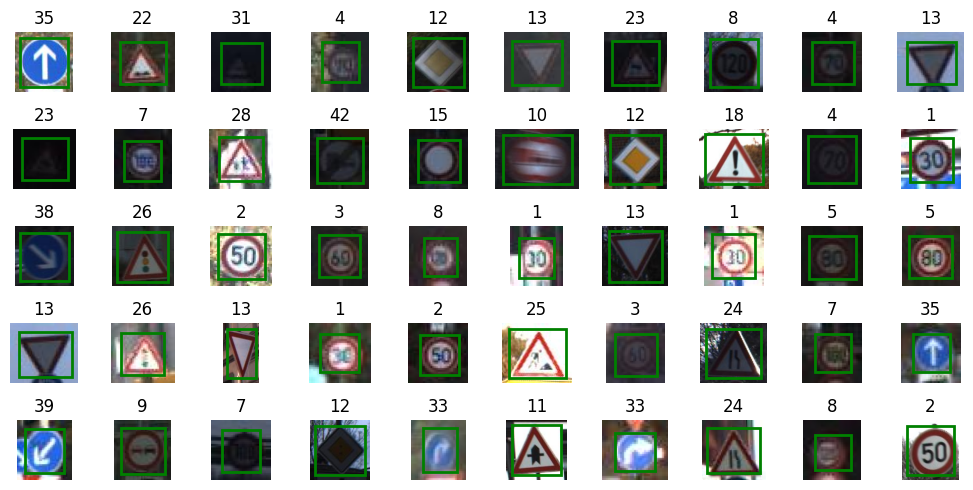

In [ ]:
# visualize some images from the test set with their labels
test_images = os.listdir('./data/yolo_detection/test/images')
rows, cols = 5, 10
fig, axes = plt.subplots(rows, cols, figsize=(10, 5))
for idx, ax in enumerate(axes.ravel()):
    if idx < len(test_images):
        # randomly select an image from the test set
        img_file = test_images[np.random.randint(len(test_images))]
        img = Image.open(os.path.join('./data/yolo_detection/test/images', img_file))
        ax.imshow(img)
        ax.axis('off')
        
        # read the label file
        label_file = img_file.replace('.jpg', '.txt')
        with open(os.path.join('./data/yolo_detection/test/labels', label_file), 'r') as f:
            label = f.read().strip()
        
        # show label roi on the image
        if label:
            class_id, bbox = label.split(' ', 1)
            bbox = list(map(float, bbox.split()))
            x_center, y_center, width, height = bbox
            
            # convert to pixel coordinates
            img_width, img_height = img.size
            x1 = int((x_center - width / 2) * img_width)
            y1 = int((y_center - height / 2) * img_height)
            x2 = int((x_center + width / 2) * img_width)
            y2 = int((y_center + height / 2) * img_height)
            
            # draw rectangle on the image
            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='green', facecolor='none')
            ax.add_patch(rect)
            ax.set_title(class_id)
        
    else:
        ax.axis('off')

plt.tight_layout()
fig.savefig('figures/' + 'detection_sample_representative' + '.jpg', dpi=700)

# Single model training and evaluation (YOLOv8s)

In [ ]:
model = YOLO("yolov8s.pt")
model.train(
    data='./data/yolo_detection/data.yaml', 
    epochs=50,
    imgsz=640,
    batch=16,
    name="./models/yolov8s",
    device=device,
)

New https://pypi.org/project/ultralytics/8.3.160 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.159  Python-3.11.9 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:/Users/tian/yolov8_project/AUV-Team14-main/data/yolo_detection/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scal

100%|██████████| 755k/755k [00:00<00:00, 1.68MB/s]

Overriding model.yaml nc=80 with nc=43

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytic

 22        [15, 18, 21]  1   2132689  ultralytics.nn.modules.head.Detect           [43, [128, 256, 512]]         
Model summary: 129 layers, 11,152,241 parameters, 11,152,225 gradients, 28.7 GFLOPs

Transferred 349/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:02<00:00, 1.89MB/s]


AMP: checks passed 
train: Fast image access  (ping: 0.10.0 ms, read: 0.50.4 MB/s, size: 2.0 KB)


train: Scanning C:\Users\tian\yolov8_project\AUV-Team14-main\data\yolo_detection\train\labels... 35288 images, 0 backgrounds, 0 corrupt: 100%|██████████| 35288/35288 [00:36<00:00, 966.89it/s] 


train: New cache created: C:\Users\tian\yolov8_project\AUV-Team14-main\data\yolo_detection\train\labels.cache
val: Fast image access  (ping: 0.20.1 ms, read: 0.10.1 MB/s, size: 1.6 KB)


val: Scanning C:\Users\tian\yolov8_project\AUV-Team14-main\data\yolo_detection\val\labels... 3921 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3921/3921 [00:06<00:00, 651.83it/s]


val: New cache created: C:\Users\tian\yolov8_project\AUV-Team14-main\data\yolo_detection\val\labels.cache
Plotting labels to runs\detect\traffic_sign_yolov86\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\traffic_sign_yolov86
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.88G     0.8132      2.243       1.34         28        640: 100%|██████████| 2206/2206 [15:14<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:34<00:00,  3.61it/s]

                   all       3921       3921      0.777      0.827      0.877      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.77G     0.5966      1.023       1.13         21        640: 100%|██████████| 2206/2206 [08:09<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:31<00:00,  3.89it/s]


                   all       3921       3921       0.86      0.889      0.911      0.811

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.77G     0.5919     0.9606      1.118         21        640: 100%|██████████| 2206/2206 [08:00<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:30<00:00,  3.98it/s]


                   all       3921       3921      0.874      0.912      0.931      0.857

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       3.9G     0.5577     0.9106      1.098         22        640: 100%|██████████| 2206/2206 [08:01<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:30<00:00,  4.05it/s]


                   all       3921       3921      0.837      0.936      0.928      0.866

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.78G     0.5001     0.8188      1.066         22        640: 100%|██████████| 2206/2206 [08:01<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:30<00:00,  3.97it/s]


                   all       3921       3921       0.91      0.958      0.964      0.908

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.75G      0.469     0.7533      1.049         17        640: 100%|██████████| 2206/2206 [08:01<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:30<00:00,  4.04it/s]


                   all       3921       3921      0.909      0.972      0.976      0.932

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.78G     0.4497     0.7142      1.039         18        640: 100%|██████████| 2206/2206 [08:01<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:30<00:00,  3.99it/s]


                   all       3921       3921       0.93      0.958      0.971      0.931

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       3.9G     0.4326      0.683      1.032         27        640: 100%|██████████| 2206/2206 [08:03<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:30<00:00,  4.08it/s]


                   all       3921       3921      0.954      0.961      0.979      0.938

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.78G     0.4206     0.6578      1.027         20        640: 100%|██████████| 2206/2206 [07:53<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:28<00:00,  4.37it/s]

                   all       3921       3921      0.941      0.972      0.982      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.75G     0.4101     0.6414      1.024         20        640: 100%|██████████| 2206/2206 [07:35<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:29<00:00,  4.13it/s]

                   all       3921       3921      0.966      0.967      0.981      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.77G     0.4017     0.6234       1.02         23        640: 100%|██████████| 2206/2206 [07:32<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:30<00:00,  4.06it/s]

                   all       3921       3921       0.98      0.984      0.992      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.75G     0.3923     0.6068      1.015         20        640: 100%|██████████| 2206/2206 [07:36<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:28<00:00,  4.27it/s]

                   all       3921       3921      0.974      0.979      0.988      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.78G     0.3869     0.5957      1.014         17        640: 100%|██████████| 2206/2206 [07:37<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:28<00:00,  4.30it/s]

                   all       3921       3921      0.981      0.974       0.99      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.75G     0.3802      0.583      1.012         27        640: 100%|██████████| 2206/2206 [07:43<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:28<00:00,  4.38it/s]

                   all       3921       3921      0.988      0.983      0.993      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.77G     0.3747     0.5722      1.008         20        640: 100%|██████████| 2206/2206 [07:36<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:32<00:00,  3.77it/s]

                   all       3921       3921       0.99      0.992      0.994      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.75G     0.3703     0.5642      1.007         20        640: 100%|██████████| 2206/2206 [07:44<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:29<00:00,  4.18it/s]

                   all       3921       3921      0.989      0.986      0.994      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.77G     0.3648     0.5481      1.005         30        640: 100%|██████████| 2206/2206 [12:51<00:00,  2.86it/s] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:29<00:00,  4.14it/s]


                   all       3921       3921      0.981      0.992      0.994      0.966

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50       3.9G     0.3604     0.5393      1.005         22        640: 100%|██████████| 2206/2206 [07:47<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:28<00:00,  4.27it/s]

                   all       3921       3921      0.988      0.991      0.994      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.77G     0.3569     0.5361      1.003         17        640: 100%|██████████| 2206/2206 [07:53<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:30<00:00,  4.09it/s]

                   all       3921       3921      0.994      0.991      0.995      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       3.9G     0.3549     0.5269      1.005         19        640: 100%|██████████| 2206/2206 [07:57<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:29<00:00,  4.12it/s]

                   all       3921       3921      0.993      0.993      0.995      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.78G     0.3509     0.5169      1.001         20        640: 100%|██████████| 2206/2206 [07:54<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:30<00:00,  4.09it/s]

                   all       3921       3921      0.992      0.994      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       3.9G     0.3478     0.5126     0.9989         21        640: 100%|██████████| 2206/2206 [07:58<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:29<00:00,  4.11it/s]

                   all       3921       3921      0.992      0.995      0.995      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.77G     0.3434     0.5016     0.9976         22        640: 100%|██████████| 2206/2206 [07:50<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:33<00:00,  3.68it/s]


                   all       3921       3921      0.992      0.996      0.995      0.969

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       3.9G     0.3406     0.4926      0.998         18        640: 100%|██████████| 2206/2206 [07:56<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:33<00:00,  3.65it/s]


                   all       3921       3921      0.994      0.996      0.995      0.969

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.78G     0.3367     0.4869     0.9948         20        640: 100%|██████████| 2206/2206 [07:53<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:28<00:00,  4.35it/s]

                   all       3921       3921      0.995      0.995      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.75G     0.3323     0.4821     0.9938         21        640: 100%|██████████| 2206/2206 [07:45<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:28<00:00,  4.39it/s]

                   all       3921       3921      0.996      0.996      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.78G     0.3336     0.4744     0.9949         25        640: 100%|██████████| 2206/2206 [07:46<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:31<00:00,  3.89it/s]

                   all       3921       3921      0.995      0.996      0.995      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       3.9G     0.3289     0.4707     0.9926         18        640: 100%|██████████| 2206/2206 [08:03<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:34<00:00,  3.54it/s]


                   all       3921       3921      0.996      0.997      0.995      0.972

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.78G     0.3255     0.4642     0.9927         20        640: 100%|██████████| 2206/2206 [07:53<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:30<00:00,  3.98it/s]


                   all       3921       3921      0.996      0.997      0.995      0.973

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.75G     0.3222     0.4572     0.9907         20        640: 100%|██████████| 2206/2206 [08:18<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:31<00:00,  3.93it/s]


                   all       3921       3921      0.996      0.997      0.995      0.972

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.77G     0.3212     0.4529     0.9899         17        640: 100%|██████████| 2206/2206 [08:18<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:31<00:00,  3.87it/s]

                   all       3921       3921      0.996      0.997      0.995      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.75G      0.318     0.4447     0.9887         19        640: 100%|██████████| 2206/2206 [08:21<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:31<00:00,  3.86it/s]


                   all       3921       3921      0.996      0.997      0.995      0.972

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.78G     0.3167      0.438     0.9894         19        640: 100%|██████████| 2206/2206 [08:21<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:30<00:00,  4.00it/s]

                   all       3921       3921      0.996      0.997      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.75G     0.3126     0.4341     0.9868         18        640: 100%|██████████| 2206/2206 [08:04<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:30<00:00,  4.03it/s]


                   all       3921       3921      0.996      0.997      0.995      0.973

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.78G     0.3097     0.4289     0.9872         18        640: 100%|██████████| 2206/2206 [08:04<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:31<00:00,  3.95it/s]


                   all       3921       3921      0.996      0.997      0.995      0.973

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.75G     0.3068     0.4226     0.9851         26        640: 100%|██████████| 2206/2206 [07:58<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:29<00:00,  4.20it/s]

                   all       3921       3921      0.997      0.997      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.78G     0.3044     0.4146     0.9826         21        640: 100%|██████████| 2206/2206 [07:57<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:28<00:00,  4.26it/s]

                   all       3921       3921      0.997      0.997      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.75G     0.3029     0.4085     0.9841         17        640: 100%|██████████| 2206/2206 [07:55<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:29<00:00,  4.15it/s]

                   all       3921       3921      0.997      0.998      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.77G     0.2991     0.4052     0.9816         25        640: 100%|██████████| 2206/2206 [07:55<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:29<00:00,  4.15it/s]

                   all       3921       3921      0.997      0.998      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.75G     0.2961     0.3939      0.981         18        640: 100%|██████████| 2206/2206 [08:08<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:30<00:00,  4.00it/s]


                   all       3921       3921      0.997      0.998      0.995      0.973
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.78G     0.3491     0.1869      1.074          8        640: 100%|██████████| 2206/2206 [08:09<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:37<00:00,  3.28it/s]


                   all       3921       3921      0.997      0.998      0.995      0.973

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.75G     0.3385     0.1789       1.06          8        640: 100%|██████████| 2206/2206 [08:13<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:30<00:00,  3.99it/s]

                   all       3921       3921      0.997      0.998      0.995      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.77G     0.3318     0.1727      1.055          8        640: 100%|██████████| 2206/2206 [08:01<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:31<00:00,  3.86it/s]


                   all       3921       3921      0.997      0.998      0.995      0.974

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.76G     0.3285     0.1687       1.05          8        640: 100%|██████████| 2206/2206 [08:01<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:30<00:00,  4.02it/s]

                   all       3921       3921      0.998      0.999      0.995      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.78G     0.3242     0.1634      1.048          8        640: 100%|██████████| 2206/2206 [07:55<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:30<00:00,  4.09it/s]

                   all       3921       3921      0.998      0.999      0.995      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.76G     0.3155      0.158      1.037          8        640: 100%|██████████| 2206/2206 [08:27<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [01:17<00:00,  1.60it/s]

                   all       3921       3921      0.998      0.999      0.995      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.77G     0.3111     0.1541      1.036          8        640: 100%|██████████| 2206/2206 [10:01<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:55<00:00,  2.21it/s]

                   all       3921       3921      0.998      0.999      0.995      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.76G     0.3073       0.15      1.031          8        640: 100%|██████████| 2206/2206 [09:49<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:35<00:00,  3.50it/s]


                   all       3921       3921      0.998      0.999      0.995      0.975

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.77G      0.302      0.147      1.026          8        640: 100%|██████████| 2206/2206 [07:48<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:27<00:00,  4.43it/s]

                   all       3921       3921      0.998      0.999      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.76G     0.2988      0.144      1.024          8        640: 100%|██████████| 2206/2206 [07:43<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:29<00:00,  4.15it/s]

                   all       3921       3921      0.998      0.999      0.995      0.975



50 epochs completed in 7.373 hours.
Optimizer stripped from runs\detect\traffic_sign_yolov86\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\traffic_sign_yolov86\weights\best.pt, 22.5MB

Validating runs\detect\traffic_sign_yolov86\weights\best.pt...
Ultralytics 8.3.159  Python-3.11.9 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 11,142,225 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:28<00:00,  4.29it/s]


                   all       3921       3921      0.998      0.999      0.995      0.975
               class_0         21         21      0.994          1      0.995      0.993
               class_1        222        222          1          1      0.995       0.97
               class_2        225        225      0.999          1      0.995      0.971
               class_3        141        141      0.997          1      0.995      0.967
               class_4        198        198          1      0.996      0.995      0.979
               class_5        186        186          1      0.981      0.995      0.973
               class_6         42         42      0.998          1      0.995       0.96
               class_7        144        144      0.999          1      0.995      0.971
               class_8        141        141          1      0.994      0.995      0.969
               class_9        147        147      0.999          1      0.995      0.976
              class_1

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001E048FBB550>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    

In [ ]:
model = YOLO("models/yolov8s/weights/best.pt")
results = model.val(
    data='data/yolo_detection/data.yaml',
    split='test',
    imgsz=640,
    batch=16,
    #save_json=True,
    #save_txt=True,
    #save_conf=True,
    plots=True,
    project="models/yolov8s",
    name="test_results",
    device=device,
)
print(results)

Model summary (fused): 72 layers, 11,142,225 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 15.14.6 MB/s, size: 1.2 KB)


val: Scanning C:\Users\janeh\Documents\GitHub\AUV-Team14\data\yolo_detection\test\labels.cache... 12630 images, 0 backgrounds, 0 corrupt: 100%|██████████| 12630/12630 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 790/790 [00:55<00:00, 14.17it/s]


                   all      12630      12630      0.949      0.942      0.959      0.935
               class_0         60         60      0.995          1      0.995      0.967
               class_1        720        720      0.992          1      0.995      0.972
               class_2        750        750      0.997      0.998      0.995      0.978
               class_3        450        450          1      0.971      0.995      0.979
               class_4        660        660          1      0.986      0.995      0.976
               class_5        630        630      0.966      0.997      0.992      0.973
               class_6        150        150          1      0.869      0.995      0.974
               class_7        450        450      0.995          1      0.993      0.966
               class_8        450        450      0.995      0.938      0.994      0.967
               class_9        480        480      0.999          1      0.995      0.972
              class_1

In [ ]:
# FIXME: Results very good. Problem with dataset or implementation?

# Comparison of different models (...)

In [ ]:
# ...